In [36]:
import gym
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
sys.path.append('../')
from common import make_env, perform_action, const_disturb_five, const_jitter_force, get_frame_skip_and_timestep
from evals import *
sys.path.append('../../')
import TD3

import pandas as pd



In [37]:
response_times = [ 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

In [38]:
for rt in response_times:
    for g_force in [0, 5, 10, 15, 20]:
        for seed in range(5):
            if not os.path.isfile('../models3/TD3_InvertedPendulum-v2_'+str(seed)+'_0.02_'+str(float(g_force))+'_'+str(rt)+'_1.0_True_256_final_actor'):
                print (rt, g_force, seed)

In [39]:
df = pd.DataFrame(columns=['seed', 'g_force', 'response_rate', 'reward', 'angle', 'jerk'])
# df = torch.load('dataframe')
default_timestep = 0.02
default_frame_skip = 2
jit_duration = 0.02
env_name = 'InvertedPendulum-v2'
delayed_env = True
                
for response_rate in response_times:
    for g_force in [0, 5, 10, 15, 20]:
        print(response_rate, g_force)
        for seed in range(5):
            states = []
            arguments = ['TD3', env_name, seed, jit_duration, float(g_force), response_rate, 1.0, delayed_env, 256, 'best']
            file_name = '_'.join([str(x) for x in arguments])
            frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, response_rate)
                    
            time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
            eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
            eval_env.env.env._max_episode_steps = 100000
            state_dim = eval_env.observation_space[0].shape[0]
            action_dim = eval_env.action_space.shape[0]
            max_action = float(eval_env.action_space.high[0])
            kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "observation_space": eval_env.observation_space,
                "max_action": max_action,
                "discount": 0.99,
                "tau": 0.005,
                "delayed_env":delayed_env
            }
            kwargs["policy_noise"] = 2 * max_action
            kwargs["noise_clip"] = 0.5 * max_action
            kwargs["policy_freq"] = 2
            policy = TD3.TD3(**kwargs)
            policy_file = file_name 
            if os.path.exists('../models3/'+policy_file+"_critic"):
                policy.load(f"../models3/{policy_file}")
                avg_reward, avg_angle, jerk, actions = eval_policy_increasing_force(policy, env_name, 10, time_change_factor, timestep, frame_skip, jit_frames, response_rate, delayed_env)
                df.loc[len(df.index)] = [seed, g_force, response_rate, avg_reward, avg_angle, jerk]
                

0.01 0
0.01 5
0.01 10
0.01 15
0.01 20
0.02 0
0.02 5
0.02 10
0.02 15
0.02 20
0.04 0
0.04 5
0.04 10
0.04 15
0.04 20
0.06 0
0.06 5
0.06 10
0.06 15
0.06 20
0.08 0
0.08 5
0.08 10
0.08 15
0.08 20
0.1 0
0.1 5
0.1 10
0.1 15
0.1 20
0.12 0
0.12 5
0.12 10
0.12 15
0.12 20
0.14 0
0.14 5
0.14 10
0.14 15
0.14 20
0.16 0
0.16 5
0.16 10
0.16 15
0.16 20
0.18 0
0.18 5
0.18 10
0.18 15
0.18 20
0.2 0
0.2 5
0.2 10
0.2 15
0.2 20


In [40]:
torch.save(df, 'dataframe_granular')

In [41]:
df = torch.load('dataframe_granular')

In [44]:
df['reward'] = df['reward'] * df['response_rate']
df['jerk'] = df['jerk'] / df['response_rate']
rewards_mean = pd.crosstab(df['g_force'], df['response_rate'], values=df['reward'], aggfunc='mean')
rewards_std = pd.crosstab(df['g_force'], df['response_rate'], values=df['reward'], aggfunc='std')

jerks = pd.crosstab(df['g_force'], df['response_rate'], values=df['jerk'], aggfunc='mean')

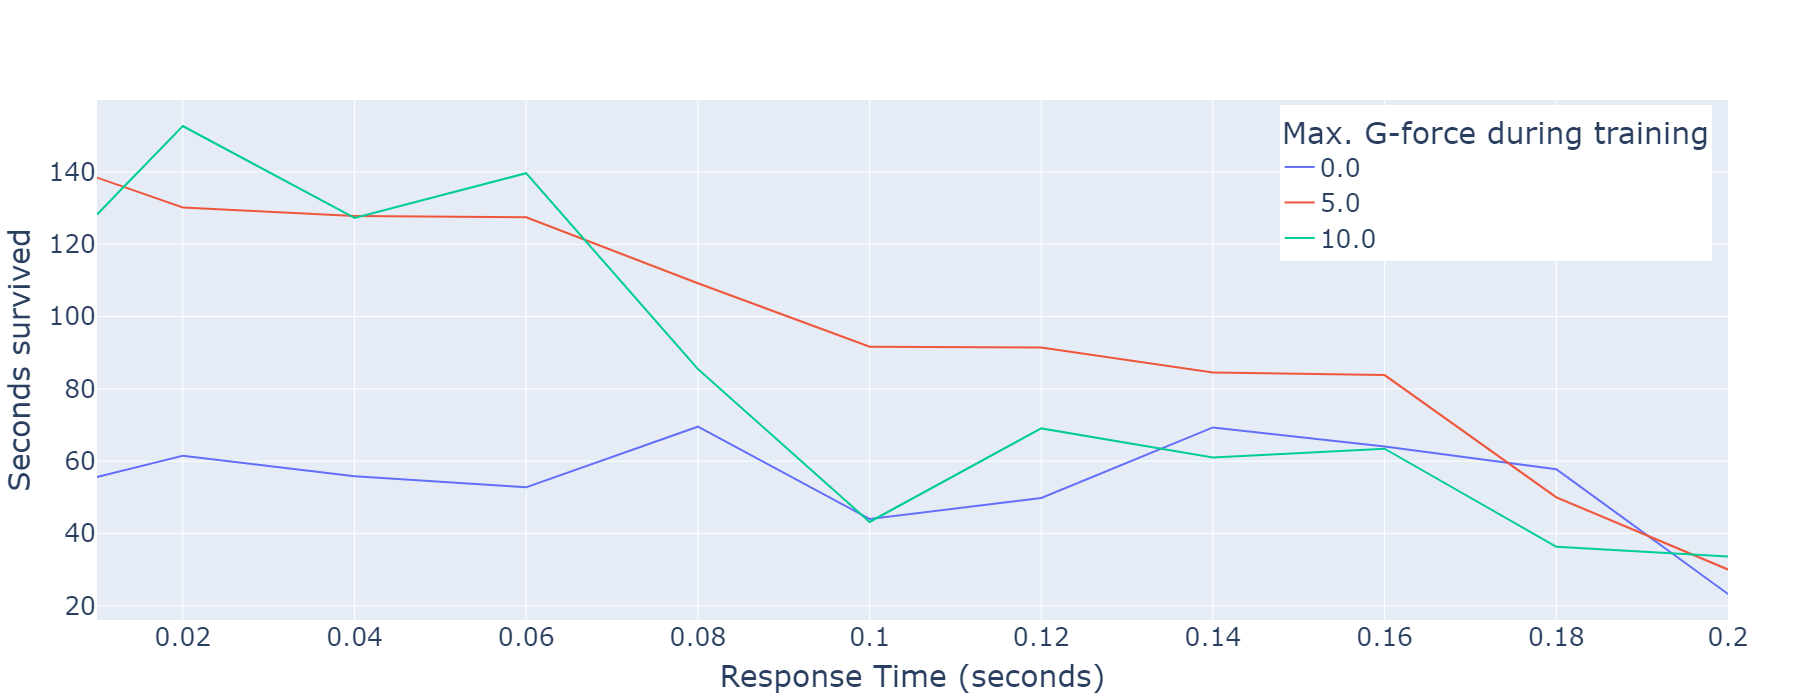

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=response_times, y=rewards_mean.T[0.0], mode='lines', name='0.0'))
fig.add_trace(go.Scatter(x=response_times, y=rewards_mean.T[5.0], mode='lines', name='5.0'))
fig.add_trace(go.Scatter(x=response_times, y=rewards_mean.T[10.0], mode='lines', name='10.0'))

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time (seconds)",
    yaxis_title="Seconds survived",
    xaxis_side='bottom',
    legend_title="Max. G-force during training",
    font=dict(size=25),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    height=700,
    width=1600
)
fig.show()

In [11]:
df.loc[(df['response_rate'] == 0.04) & (df['g_force'] == 10)]

,seed,g_force,response_rate,reward,angle,jerk
60,0.0,10.0,0.04,88.388,149.011131,10.008103
61,1.0,10.0,0.04,144.132,108.439308,2.545744
62,2.0,10.0,0.04,150.276,102.312935,2.575963
63,3.0,10.0,0.04,110.508,77.384638,2.647154
64,4.0,10.0,0.04,153.488,159.202030,3.873564


In [35]:
df

,seed,g_force,response_rate,reward,angle,jerk
0,0.0,0.0,0.01,62.886,81.105589,469.828769
1,1.0,0.0,0.01,23.587,34.730926,1119.581984
2,2.0,0.0,0.01,111.364,540.722473,975.102757
3,3.0,0.0,0.01,28.847,79.051412,1651.702349
4,4.0,0.0,0.01,51.922,89.095796,1373.177418
...,...,...,...,...,...,...
270,0.0,20.0,0.20,12.920,2.325255,3.100658
271,1.0,20.0,0.20,49.060,7.447988,7.367480
272,2.0,20.0,0.20,6.900,2.135142,6.953089
273,3.0,20.0,0.20,23.360,4.099474,10.662767


In [11]:
eval_env.env.env.env.frame_skip

AttributeError: 'InvertedPendulumEnv' object has no attribute 'env'

In [12]:
eval_env.frame_skip

1